<a href="https://colab.research.google.com/github/nahumsa/Tensorflow-Quantum/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised learning using Quantum Neural Networks

This code is based on this [notebook](https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb).

In [0]:
!pip install --upgrade tensorflow==2.1.0

In [0]:
!pip install tensorflow-quantum

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Data
In this tutorial we shall classify between numbers 1 and 3 on the MNIST.

The procedure will be: 

    1.1) Load data from keras.datasets
    1.2) Filter only the numbers that we want to classify
    1.3) Rescale images to fit on a Quantum Computer
    1.4) Remove contradictory examples
    1.5) Convert to binary and then to Quantum Circuits
    1.6) Convert to tensorflow

## 1.1) Load data from keras.datasets

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_train))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 60000


## 1.2) Filter only the numbers that we want to classify

In [0]:
def filter_13(x,y):
  mask = (y == 1) | (y == 3)
  x,y = x[mask], y[mask]
  #Convert y to binary 
  y = (y == 3)
  return x,y

In [4]:
x_train, y_train = filter_13(x_train, y_train)
x_test, y_test = filter_13(x_test, y_test)

print(f"Number of filtered training examples: {x_train.shape[0]}")
print(f"Number of filtered test examples: {x_test.shape[0]}")

Number of filtered training examples: 12873
Number of filtered test examples: 2145


## 1.3) Rescale images to fit on a Quantum Computer

To resize the image we use the `tf.image.resize` and we need to use `.numpy()` in order to convert from `tf.Tensor` to `np.arrays`

In [0]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

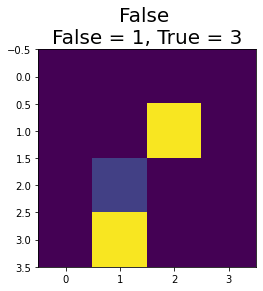

In [6]:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.title(f'{y_train[0]} \nFalse = 1, True = 3', size=20)
plt.show()

## 1.4) Remove contradictory examples

In [0]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      #Check if you get the same label after applying the same X
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_1 = sum(1 for value in mapping.values() if True in value)
    num_3 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 1s: ", num_1)
    print("Number of 3s: ", num_3)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [8]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 6851
Number of 1s:  4961
Number of 3s:  2176
Number of contradictory images:  286

Initial number of examples:  12873
Remaining non-contradictory examples:  7907


## 1.5) Convert to binary and then to Quantum Circuits
Since the images are between 0 and 1, we have to set a threshold to transform the image into binary.

In [0]:
threshold = 0.5

x_train_bin = np.array(x_train_nocon > threshold)
x_test_bin = np.array(x_test_small > threshold)

In [0]:
def convert2circuit(image):
  values = image.flatten()
  qubits = cirq.GridQubit.rect(4,4)
  circuit = cirq.Circuit()
  for i,val in enumerate(values):
    if val:
      circuit.append(cirq.X(qubits[i]))
  return circuit

x_train_circ = [convert2circuit(x) for x in x_train_bin]
x_test_circ = [convert2circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


The indices shoud be: [array([1, 2]), array([3, 1])]


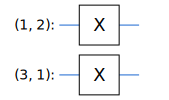

In [11]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
print(f'The indices shoud be: {[i for i in indices]}')
SVGCircuit(x_train_circ[0])

## 1.6) Convert to tensorflow

In [0]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# 2) Quantum Neural Network (QNN)

For the QNN we will follow the TFQ whitepaper. That is, we construct a Parametrized Quantum Circuit (PQC) which is done by the `CircuitLayerBuild` to create layers with entangling gates through all qubits.

## 2.1) Model circuit

In [0]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

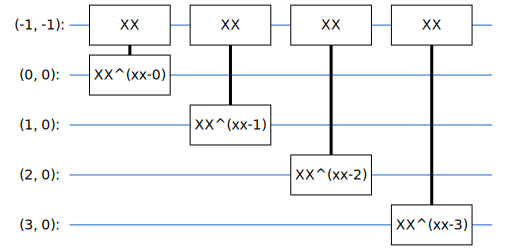

In [30]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout= cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Here we will build a 4x4 circuit with XX and ZZ gates with readout on the (-1,-1) qubit.

In [0]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout= readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [0]:
model_circuit, model_readout = create_quantum_model()

## 2.2) Wrapping on a Keras Model

To wrap our PQC into a keras model, we use the `tfq.layers.PQC` which gets a parametrized circuit and outputs the readout of this optimized PQC.

In [0]:
# Build the Keras model.
model_q = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [50]:
model_q.compile(
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

model_q.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_2 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


## 2.3) Training the quantum Model

In [0]:
EPOCHS = 5
BATCH_SIZE = 32

NUM_EXAMPLES = 500 #len(x_train_tfcirc)

In [0]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
x_test_tfcirc_sub = x_test_tfcirc[:NUM_EXAMPLES]
y_train_sub = y_train_nocon[:NUM_EXAMPLES]
y_test_sub = y_test[:NUM_EXAMPLES]
y_train_sub = y_train_sub.astype('int')

In [58]:
qnn_history = model_q.fit(
      x_train_tfcirc_sub, y_train_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc_sub, y_test_sub))

qnn_results = model_q.evaluate(x_test_tfcirc, y_test)

Train on 500 samples, validate on 500 samples
Epoch 1/5
500/500 [==============================] - 285s 571ms/sample - loss: 3.8020 - accuracy: 0.3840 - val_loss: 2.2182 - val_accuracy: 0.5300
Epoch 2/5
500/500 [==============================] - 285s 569ms/sample - loss: 2.9503 - accuracy: 0.3840 - val_loss: 2.1189 - val_accuracy: 0.5300
Epoch 3/5
500/500 [==============================] - 285s 571ms/sample - loss: 2.8082 - accuracy: 0.3840 - val_loss: 2.0680 - val_accuracy: 0.5300
Epoch 4/5
500/500 [==============================] - 285s 571ms/sample - loss: 2.1676 - accuracy: 0.3840 - val_loss: 1.2992 - val_accuracy: 0.5300
Epoch 5/5
2145/2145 [==============================] - 38s 18ms/sample - loss: 1.5153 - accuracy: 0.5291


# 3) Classical Neural Net

Let's compare the QNN with a simple FCN.

In [59]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model_c = create_classical_model()
model_c.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model_c.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [60]:
model_c.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model_c.evaluate(x_test, y_test)

Train on 12873 samples, validate on 2145 samples
2145/2145 [==============================] - 0s 119us/sample - loss: 0.0063 - accuracy: 0.9986


The previous model is unfair, because we are comparing 1k parameters with only 16 parameters on the QNN. Thus we construct a more 'fair' model that is simillar to the accuracy obtained by the QNN.

In [61]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model_cf = create_fair_classical_model()
model_cf.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model_cf.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [62]:
model_cf.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=EPOCHS,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model_cf.evaluate(x_test_bin, y_test)

Train on 7907 samples, validate on 2145 samples
Epoch 1/5
7907/7907 - 1s - loss: 0.7342 - accuracy: 0.3424 - val_loss: 0.7171 - val_accuracy: 0.5291
Epoch 2/5
7907/7907 - 0s - loss: 0.7012 - accuracy: 0.3430 - val_loss: 0.7116 - val_accuracy: 0.5301
Epoch 3/5
7907/7907 - 0s - loss: 0.6672 - accuracy: 0.3637 - val_loss: 0.7048 - val_accuracy: 0.5608
Epoch 4/5
7907/7907 - 0s - loss: 0.6226 - accuracy: 0.5307 - val_loss: 0.7020 - val_accuracy: 0.6709
Epoch 5/5
7907/7907 - 0s - loss: 0.5916 - accuracy: 0.7122 - val_loss: 0.7023 - val_accuracy: 0.5333
2145/2145 [==============================] - 0s 85us/sample - loss: 0.7023 - accuracy: 0.5333


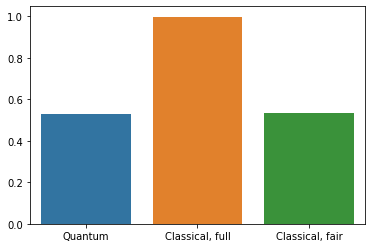

In [63]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])
plt.show()